In [1]:
import os
import tempfile

import imageio
import numpy as np
import rembg
import torch
from diffusers import DiffusionPipeline, EulerAncestralDiscreteScheduler
from einops import rearrange
from huggingface_hub import hf_hub_download
from omegaconf import OmegaConf
from PIL import Image
from pytorch_lightning import seed_everything
from torchvision.transforms import v2
from tqdm import tqdm

from src.utils.camera_util import (
    FOV_to_intrinsics,
    get_circular_camera_poses,
    get_zero123plus_input_cameras,
)
from src.utils.infer_util import images_to_video, remove_background, resize_foreground
from src.utils.mesh_util import save_glb, save_obj
from src.utils.train_util import instantiate_from_config


/home/weiqf/miniconda3/envs/instantmesh/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
state_dict = torch.load("ckpts/step=00062000-v1.ckpt", map_location="cpu")

keys_to_remove = {
    "betas",
    "alphas_cumprod",
    "alphas_cumprod_prev",
    "sqrt_alphas_cumprod",
    "sqrt_one_minus_alphas_cumprod",
    "sqrt_recip_alphas_cumprod",
    "sqrt_recipm1_alphas_cumprod",
}

updated_state_dict = {
    key.replace("unet.unet.", ""): value
    for key, value in state_dict["state_dict"].items()
    if not any(k in key for k in keys_to_remove)
}


In [11]:
print("Loading diffusion model ...")
pipeline = DiffusionPipeline.from_pretrained(
    "sudo-ai/zero123plus-v1.2",
    custom_pipeline="zero123plus",
    torch_dtype=torch.float16,
)
pipeline.scheduler = EulerAncestralDiscreteScheduler.from_config(
    pipeline.scheduler.config, timestep_spacing="trailing"
)

pipeline.unet.load_state_dict(updated_state_dict, strict=True)

pipeline = pipeline.to("cuda")


Loading diffusion model ...


/home/weiqf/miniconda3/envs/instantmesh/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading pipeline components...: 100%|██████████| 8/8 [00:02<00:00,  3.16it/s]


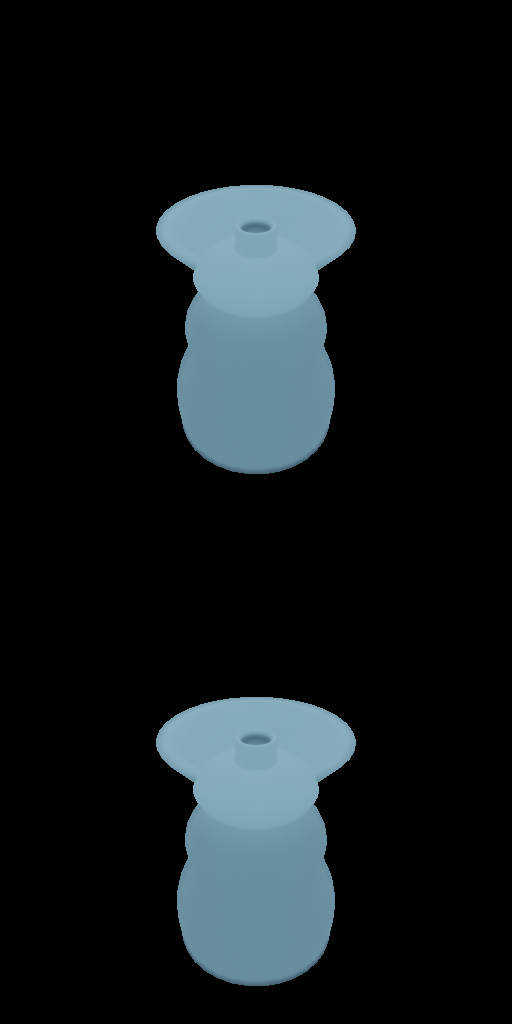

In [16]:
from torchvision.transforms import ToTensor, ToPILImage

input_image = Image.open("002.png").convert("RGB")

# Get the dimensions of the input image
width, height = input_image.size

# Create a new image with double the width of the original image
new_image = Image.new("RGB", (width, height*2))

# Paste the input image twice: once on the left and once on the right
new_image.paste(input_image, (0, 0))  # Left
new_image.paste(input_image, (0, width))  # Right

new_image




100%|██████████| 50/50 [00:04<00:00, 10.56it/s]


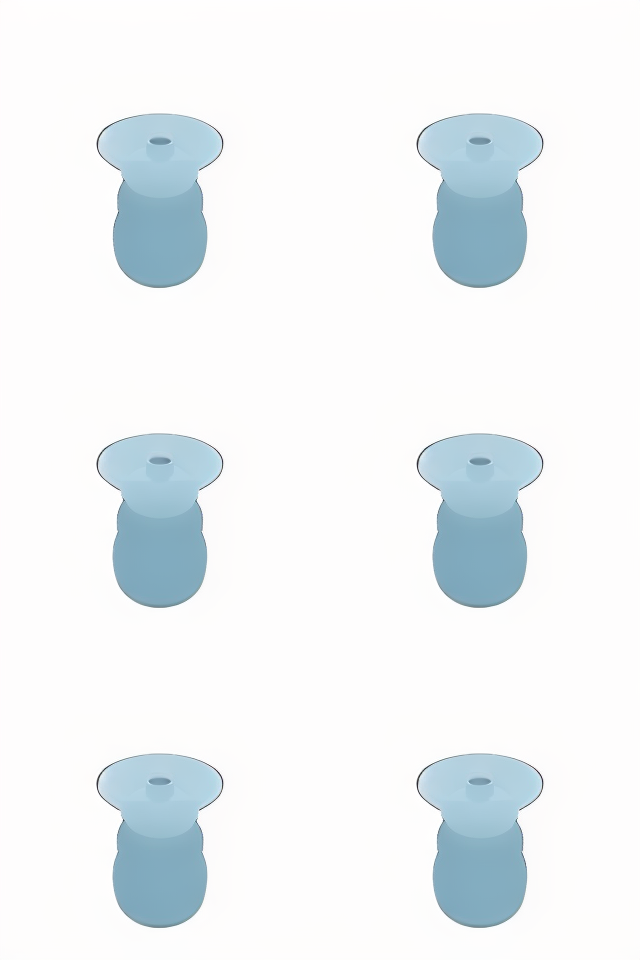

In [17]:
# Perform inference
generator = torch.Generator(device="cuda")
output = pipeline(
    image=new_image,
    num_inference_steps=50,  # Adjust the number of steps as needed
    generator=generator,
).images[0]

# Save or display the output image
output_image_path = "output_image.png"
output.save(output_image_path)
output
